In [4]:
import pandas as pd
from IPython.display import display

# Carregar o dataset
df = pd.read_csv('wiki_movie_plots_deduped.csv')


# Remover linhas onde o gênero é "unknown"
df = df[df['Genre'] != 'unknown']

# Contar quantos filmes de cada gênero temos no dataset
genre_counts = df['Genre'].value_counts()

# Exibir a contagem dos filmes por gênero
print(genre_counts.head(10))

Genre
drama        5964
comedy       4379
horror       1167
action       1098
thriller      966
romance       923
western       865
crime         568
adventure     526
musical       467
Name: count, dtype: int64


Para nao ficar muito desbalanceado e acelerar o treinamento, decidimos escolher apenas os gêneros com mais de 800 registros

In [5]:
# Filtrar apenas os gêneros desejados
selected_genres = ['drama','comedy','horror', 'action', 'thriller', 'romance','western']
# selected_genres = ['thriller', 'romance','western']
# selected_genres = ['thriller', 'romance']
df_filtered = df[df['Genre'].isin(selected_genres)]

# Exibir as 10 primeiras linhas do dataset filtrado
display(df_filtered[['Title', 'Genre', 'Plot']].head(10))

,Title,Genre,Plot
6,The Great Train Robbery,western,The film opens with two bandits breaking into ...
7,The Suburbanite,comedy,The film is about a family who move to the sub...
14,How Brown Saw the Baseball Game,comedy,Before heading out to a baseball game at a nea...
15,Laughing Gas,comedy,The plot is that of a black woman going to the...
16,The Adventures of Dollie,drama,On a beautiful summer day a father and mother ...
17,The Black Viper,drama,A thug accosts a girl as she leaves her workpl...
18,A Calamitous Elopement,comedy,A young couple decides to elope after being ca...
20,A Christmas Carol,drama,No prints of the first American film adaptatio...
21,The Fight for Freedom,western,The film opens in a town on the Mexican border...
22,At the Altar,drama,A rejected admirer sets up a trap to kill his ...


# Tokenização, StopWords e Lematização

In [6]:
import spacy

# Carregar o modelo de linguagem do spacy para lematização em inglês
nlp = spacy.load("en_core_web_sm")

# Função para tokenizar, remover stopwords (token.is_stop) e lematizar cada plot
def preprocess_text(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    return lemmatized_text

# Aplicar a tokenização e lematização na coluna 'Plot'
df_filtered['Processed_Plot'] = df_filtered['Plot'].apply(preprocess_text)

# Exibir as 10 primeiras linhas com o plot processado
display(df_filtered[['Title', 'Genre', 'Processed_Plot']].head(10))


/tmp/ipykernel_222255/2990915766.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Processed_Plot'] = df_filtered['Plot'].apply(preprocess_text)


,Title,Genre,Processed_Plot
6,The Great Train Robbery,western,film open bandit break railroad telegraph offi...
7,The Suburbanite,comedy,film family suburb hope quiet life thing start...
14,How Brown Saw the Baseball Game,comedy,head baseball game nearby ballpark sport fan M...
15,Laughing Gas,comedy,plot black woman go dentist toothache give lau...
16,The Adventures of Dollie,drama,beautiful summer day father mother daughter Do...
17,The Black Viper,drama,thug accost girl leave workplace man rescue th...
18,A Calamitous Elopement,comedy,young couple decide elope catch midst romantic...
20,A Christmas Carol,drama,print american film adaptation Christmas Carol...
21,The Fight for Freedom,western,film open town mexican border poker game go lo...
22,At the Altar,drama,reject admirer set trap kill sweetheart fiance...


# Padding e Limitando Tokens de Plot a 500

500 engloba > 90% dos tamanhos de Plot

In [7]:
# Calcular o tamanho médio e máximo dos plots em tokens
token_counts = df_filtered['Processed_Plot'].apply(lambda x: len(x.split()))
average_token_count = token_counts.mean()
max_token_count = token_counts.max()
third_quartile = token_counts.quantile(0.75)  # 3º quartil (75% dos dados)
ninety_percentile = token_counts.quantile(0.90)  # 90º percentil

# Exibir as estatísticas sobre a contagem de tokens
print(f"Tamanho médio dos plots em tokens: {average_token_count}")
print(f"Tamanho máximo dos plots em tokens: {max_token_count}")
print(f"3º Quartil dos plots em tokens: {third_quartile}")
print(f"90º Percentil dos plots em tokens: {ninety_percentile}")


Tamanho médio dos plots em tokens: 186.8996875406848
Tamanho máximo dos plots em tokens: 1999
3º Quartil dos plots em tokens: 290.0
90º Percentil dos plots em tokens: 394.0


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Definir o limite de tokens
MAX_TOKENS = 500

# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_filtered['Processed_Plot'])

# Converter os textos processados em sequências numéricas
sequences = tokenizer.texts_to_sequences(df_filtered['Processed_Plot'])

# Truncar ou preencher as sequências para garantir que todas tenham o mesmo comprimento
X = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post', truncating='post')


2024-11-21 13:32:21.754913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732206741.809237  222255 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732206741.824538  222255 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 13:32:21.970012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Label Encoding do Gênero

In [9]:
from sklearn.preprocessing import LabelEncoder

# Codificar os gêneros como números
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_filtered['Genre'])

# Exibir as primeiras 10 codificações de gêneros
print(y[:10])


[6 1 1 1 2 2 1 2 6 2]


# Divisão de Dados  

In [10]:
from sklearn.model_selection import train_test_split
import time

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar as dimensões dos dados
print(f"Quantidade de Palavras distintas: {len(tokenizer.word_index)}")
print(f"Tamanho do treinamento - (Plots de filmes x Num palavras por plot): {X_train.shape}")
print(f"Tamanho do teste - (Plots de filmes x Num palavras por plot): {X_test.shape}")
print(f"Primeiro Plot: {X_train[0]}")


# Dividir o conjunto de treino em treino e validação (70% para treino, 30% para validação)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

Quantidade de Palavras distintas: 74678
Tamanho do treinamento - (Plots de filmes x Num palavras por plot): (12289, 500)
Tamanho do teste - (Plots de filmes x Num palavras por plot): (3073, 500)
Primeiro Plot: [20486   773    21   195  6102   300   647   166   456   246  3957  4485
   551   470  1049 10351   306    84 15075   136   688   817   267   324
  6916  1643   135   309   773   161  1270  1173   306   135  9008  1811
  1133     1    93    47   365   773    71   309  1111   267   324     4
    45   306 34992    60   267   324   188  6102  2714    12 27843   309
   280  2851   454   321   598   576     1   309   773    23   576 15075
   136   106     8  1173   306  1270     8  1173  2293 11433  2084  5490
   728     3    51   952   373    33    49 10029  1173     1   204  3424
  5490     5   267   324  1163   201   593  5490   917   241   273   267
   324    38   309  1111  5490  5275   773    77   284   952   373    98
    15    16   773    23    27   450   208  9788  2949  4322

# 1. Embedding Simples

In [ ]:
start_time = time.time()

In [ ]:
print(len(tokenizer.word_index))

74678


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

MAX_TOKENS=500


# Construir o modelo simples com embedding
def embedding_simples():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=200, input_length=MAX_TOKENS)) #output: para cada plot uma matriz 500x200
    model.add(Dropout(0.4))  # Dropout para evitar overfitting
    model.add(GlobalAveragePooling1D())  # Agora temos um vetor de 200 dimensões para cada plot. Tirou-se a média das 500 palavras dimensao por dimensao (200 final). 
    model.add(Dense(128, activation='relu'))  # Camada densa após o embedding
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Número de classes (gêneros)

    # Compilar o modelo
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# Inicializar o modelo
modelo1_embedding_simples = embedding_simples()

# Configurar o EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitorar a perda no conjunto de validação
    patience=3,                # Número de épocas sem melhoria antes de parar
    restore_best_weights=True, # Restaurar os melhores pesos após parar
    verbose=1                  # Exibir mensagens durante o processo
)

# Treinar o modelo com EarlyStopping
history = modelo1_embedding_simples.fit(
    X_train_split, y_train_split, 
    epochs=10,                  # Número máximo de épocas
    batch_size=64, 
    validation_data=(X_val_split, y_val_split), 
    callbacks=[early_stopping]  # Adicionar o callback
)


Epoch 1/10


/home/digolira/Documents/ML/Anderson/PLN/Projetin/archive (2)/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
W0000 00:00:1732201433.592271  170704 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.3693 - loss: 1.6684 - val_accuracy: 0.3954 - val_loss: 1.5841
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.4091 - loss: 1.5459 - val_accuracy: 0.4486 - val_loss: 1.4928
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.4943 - loss: 1.3588 - val_accuracy: 0.4679 - val_loss: 1.2846
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.6151 - loss: 1.0724 - val_accuracy: 0.4345 - val_loss: 1.3545
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.6507 - loss: 0.9426 - val_accuracy: 0.6002 - val_loss: 1.1049
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.7413 - loss: 0.7429 - val_accuracy: 0.6241 - val_loss: 1.0616
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.7669 - loss: 0.6593 - val_accuracy: 0.5975 - val_loss: 1.1088
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.7879 - loss: 0.5899 - val

In [ ]:
# Avaliar o modelo
loss, accuracy = modelo1_embedding_simples.evaluate(X_test, y_test)
print(f"Accuracy no conjunto de teste: {accuracy * 100:.2f}%")


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6225 - loss: 1.0634
Accuracy no conjunto de teste: 63.07%


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def gerar_matriz_confusao(X_test, y_test, modelo, label_encoder):
    # Realizar previsões no conjunto de teste
    y_pred = modelo.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter probabilidades para classes

    # Calcular a matriz de confusão
    cm = confusion_matrix(y_test, y_pred_classes)
    
    # Calcular recall e precisão por classe
    recall = np.diag(cm) / np.sum(cm, axis=1)  # Recall por classe
    precision = np.diag(cm) / np.sum(cm, axis=0)  # Precisão por classe
    
    # Calcular a acurácia geral
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)  # Acurácia geral

    # Criar um DataFrame para exibir as métricas
    metrics_df = pd.DataFrame({
        'Classe': label_encoder.classes_,
        'Recall': recall,
        'Precisão': precision
    })

    # Exibir métricas por classe
    print("\nMétricas por classe:")
    print(metrics_df)
    
    # Exibir a acurácia geral
    print(f"\nAcurácia Geral: {100*accuracy:.2f}%")
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Matriz de Confusão')
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.show()

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Métricas por classe:
     Classe    Recall  Precisão
0    action  0.359091  0.589552
1    comedy  0.667413  0.658564
2     drama  0.803018  0.601759
3    horror  0.615721  0.762162
4   romance  0.162921  0.630435
5  thriller  0.193717  0.359223
6   western  0.579882  0.907407

Acurácia Geral: 63.07%


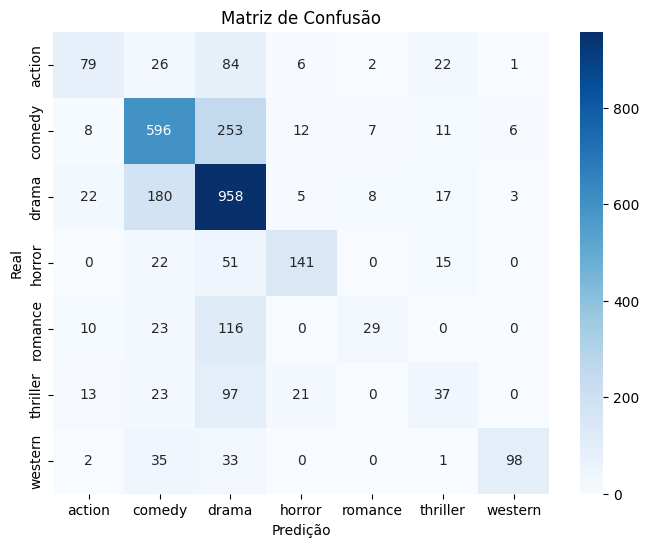

In [ ]:
gerar_matriz_confusao(X_test, y_test, modelo1_embedding_simples, label_encoder)

In [ ]:
# Marcar o fim
end_time = time.time()

# Calcular e imprimir o tempo de execução
execution_time_embedding = end_time - start_time
print(f"Tempo de execução: {execution_time_embedding:.6f} segundos")

Tempo de execução: 174.539908 segundos


# 2. GLOVE

In [ ]:
start_time = time.time()

In [ ]:
import gensim.models
from tensorflow.keras.utils import to_categorical

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
# Converter y_train_split e y_val_split para one-hot encoding
y_train_split = to_categorical(y_train_split, num_classes=len(selected_genres))
y_val_split = to_categorical(y_val_split, num_classes=len(selected_genres))
y_test_split = to_categorical(y_test, num_classes=len(selected_genres))


# Carregar o modelo salvo
# glove_model = gensim.models.KeyedVectors.load("glove-wiki-gigaword-100.model")
glove_model = gensim.models.KeyedVectors.load("glove-wiki-gigaword-200.model")

# Criar a matriz de embeddings
embedding_dim = 200  # Dimensão do vetor de palavras (correspondente ao modelo GloVe)

# Criar a matriz de embeddings
# Aqui basicamente vai criar uma matriz com todas 76 mil palavras do vocabulário...
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

# Preencher a matriz com os embeddings das palavras
# tokenizer.word_index = {     'thrill': 1,'story': 2 ........,'love': 12,'betrayal': 76000}
# embedding matrix [1] = vetor do GLove de Thrill.. embedding matrix[2] = vetor do glove de Story... etc...
# Se a palavra não tiver representação no glove , atribui-se [0,0,0,0,0]
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_model.get_vector(word) if word in glove_model else None
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### LSTM - Pós Glove

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, GlobalMaxPooling1D,  GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam


def glove():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=MAX_TOKENS,
                        trainable=True))  # Embeddings treináveis
    # Camada LSTM bidirecional
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)))
    model.add(GlobalMaxPooling1D())  # Reduz as saídas da LSTM para uma dimensão fixa
    # Camadas densas para a classificação
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))  # Aumentar os neurônios para maior capacidade
    model.add(Dense(len(selected_genres), activation='softmax'))  # Saída com softmax para classificação
    # Compilar o modelo
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# modelo2_glove = glove()
modelo2_glove=glove()

/home/digolira/Documents/ML/Anderson/PLN/Projetin/archive (2)/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 131s 948ms/step - accuracy: 0.3769 - loss: 1.6042 - val_accuracy: 0.5745 - val_loss: 1.1321
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 128s 953ms/step - accuracy: 0.5706 - loss: 1.1042 - val_accuracy: 0.6197 - val_loss: 0.9876
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 128s 949ms/step - accuracy: 0.6840 - loss: 0.8439 - val_accuracy: 0.6569 - val_loss: 0.9104
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 130s 967ms/step - accuracy: 0.7832 - loss: 0.6070 - val_accuracy: 0.6257 - val_loss: 1.1003
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 132s 979ms/step - accuracy: 0.8551 - loss: 0.4206 - val_accuracy: 0.6376 - val_loss: 1.1570
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 131s 971ms/step - accuracy: 0.9178 - loss: 0.2492 - val_accuracy: 0.6314 - val_loss: 1.3943
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


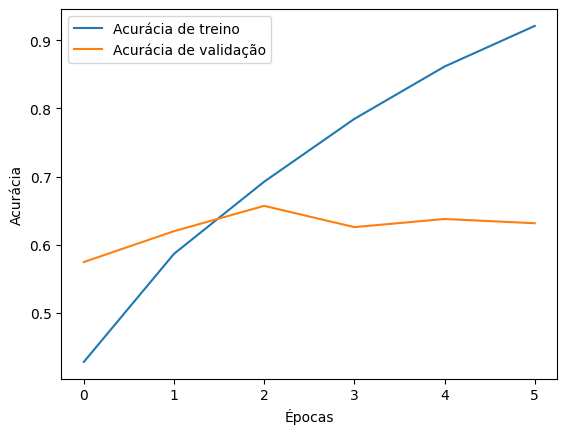

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurar o EarlyStopping para monitorar a acurácia de validação
early_stopping = EarlyStopping(monitor='val_loss',  # Pode monitorar 'val_loss' ou 'val_accuracy'
                               patience=3,  # Número de épocas sem melhoria para interromper o treinamento
                               restore_best_weights=True,  # Restaurar os melhores pesos após o treinamento
                               verbose=1)  # Exibir informações sobre o processo de parada

# Treinar o modelo com mais épocas e EarlyStopping
history = modelo2_glove.fit(X_train_split, y_train_split,
                    epochs=50,  # Aumentando o número de épocas
                    batch_size=64, 
                    validation_data=(X_val_split, y_val_split),
                    callbacks=[early_stopping])  # Adicionar o callback



# Plotar a acurácia de treino e validação
plt.plot(history.history['accuracy'], label='Acurácia de treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()


## Avaliando

In [ ]:
y_test_split = to_categorical(y_test, num_classes=len(selected_genres))


In [ ]:
# Avaliar o modelo nos dados de teste
test_loss, test_accuracy = modelo2_glove.evaluate(X_test, y_test_split, verbose=2)
print(f"Acurácia do modelo nos dados de teste: {test_accuracy * 100:.2f}%")

# Fazer previsões para novos dados (exemplo: prever o gênero de um novo plot)
sample_plot = ["A young man embarks on a journey to discover his true identity and falls in love."]
sample_seq = tokenizer.texts_to_sequences(sample_plot)
sample_pad = pad_sequences(sample_seq, maxlen=MAX_TOKENS, padding='post', truncating='post')

# Fazer a previsão
pred = modelo2_glove.predict(sample_pad)
predicted_genre = label_encoder.inverse_transform(np.argmax(pred, axis=1))

print(f"Gênero previsto: {predicted_genre[0]}")


97/97 - 14s - 140ms/step - accuracy: 0.6655 - loss: 0.8949
Acurácia do modelo nos dados de teste: 66.55%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Gênero previsto: drama


97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step

Métricas por classe:
     Classe    Recall  Precisão
0    action  0.577273  0.566964
1    comedy  0.745801  0.676829
2     drama  0.684828  0.700086
3    horror  0.825328  0.705224
4   romance  0.337079  0.458015
5  thriller  0.209424  0.363636
6   western  0.863905  0.772487

Acurácia Geral: 66.55%


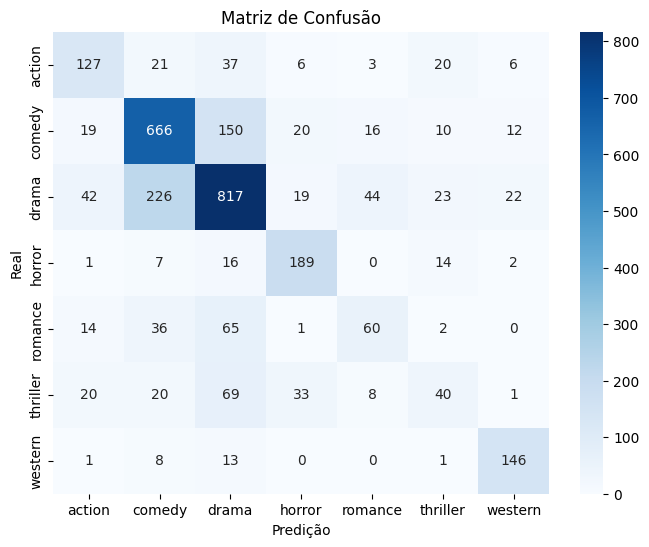

In [ ]:
gerar_matriz_confusao(X_test, y_test, modelo2_glove, label_encoder)

In [ ]:
# Marcar o fim
end_time = time.time()

# Calcular e imprimir o tempo de execução
execution_time_glove = end_time - start_time
print(f"Tempo de execução: {execution_time_glove:.6f} segundos")

Tempo de execução: 810.166220 segundos


# 3. BAG OF WORDS

In [ ]:
start_time = time.time()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, Bidirectional, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Definir o número máximo de palavras (10.000 mais frequentes)
MAX_FEATURES = 13000

# Criar o Bag of Words (BoW) usando CountVectorizer
vectorizer = CountVectorizer(max_features=MAX_FEATURES)
X_bow = vectorizer.fit_transform(df_filtered['Processed_Plot']).toarray()

# BOW é diferente, enquanto o glove tinham 200 dimensões por palavra, BOW tem 10k dimensões por Plot. 

# Reshape para 10 partes de 1000 palavras cada (1000x10)
X_bow = X_bow.reshape(X.shape[0], 10, 1300)

print(X_bow.shape)
print(f"""X_bow.shape - número plots {X_bow.shape[0]},
       Número de quebras do plot p facilitar o processamento {X_bow.shape[1]}, 
       Número de Palavras em cada quebra {X_bow.shape[2]}.
         """)

# Dividir os dados pq o formato ta diferente..
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y, test_size=0.2, random_state=42)


# Dividir o conjunto de treino em treino e validação (70% para treino, 30% para validação)
X_train_bow, X_val_bow, y_train_bow, y_val_bow = train_test_split(X_train_bow, y_train_bow, test_size=0.3, random_state=42)

(15362, 10, 1300)
X_bow.shape - número plots 15362,
       Número de quebras do plot p facilitar o processamento 10, 
       Número de Palavras em cada quebra 1300.
         


/home/digolira/Documents/ML/Anderson/PLN/Projetin/archive (2)/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15


2024-11-21 13:17:00.529371: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 894608000 exceeds 10% of free system memory.


269/269 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4832 - loss: 1.3804 - val_accuracy: 0.6140 - val_loss: 1.0282
Epoch 2/15
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7556 - loss: 0.6766 - val_accuracy: 0.6116 - val_loss: 1.0764
Epoch 3/15
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8421 - loss: 0.4282 - val_accuracy: 0.5926 - val_loss: 1.3366
Epoch 4/15
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9007 - loss: 0.2815 - val_accuracy: 0.5932 - val_loss: 1.5699


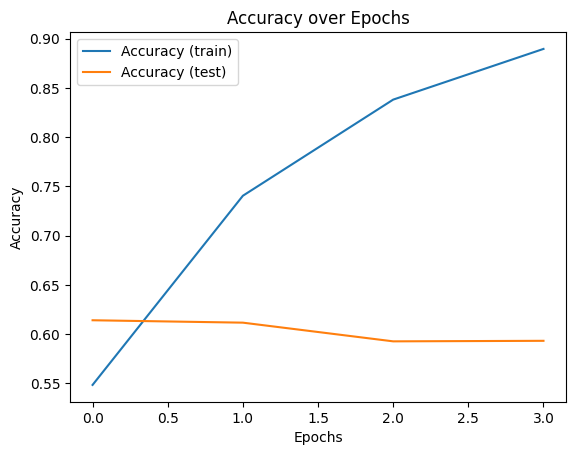

In [ ]:


def bow():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=128, return_sequences=True, input_shape=(10, 1300))))

    model.add(Flatten())  
    # Camadas densas para a classificação
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))  # Aumentar os neurônios para maior capacidade

    # Camada densa final para classificação
    model.add(Dense(len(selected_genres), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# Instanciar o modelo
modelo3_bow = bow()

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a ser monitorada
    patience=3,              # Número de épocas sem melhora antes de parar
    restore_best_weights=True  # Restaurar os pesos da melhor época
)

# Treinar o modelo com Early Stopping
history = modelo3_bow.fit(
    X_train_bow, y_train_bow,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_bow, y_val_bow),
    callbacks=[early_stopping]  # Adicionar o callback de Early Stopping
)

# Plotar os gráficos de precisão
plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (test)')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:

# Avaliar o modelo
loss, accuracy = modelo3_bow.evaluate(X_test_bow, y_test_bow)
print(f'Accuracy on test data: {accuracy*100:.2f}%')



97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6158 - loss: 1.0470
Accuracy on test data: 61.99%


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Métricas por classe:
     Classe    Recall  Precisão
0    action  0.277273  0.655914
1    comedy  0.602464  0.673342
2     drama  0.796312  0.581751
3    horror  0.689956  0.661088
4   romance  0.325843  0.487395
5  thriller  0.120419  0.534884
6   western  0.692308  0.795918

Acurácia Geral: 61.99%


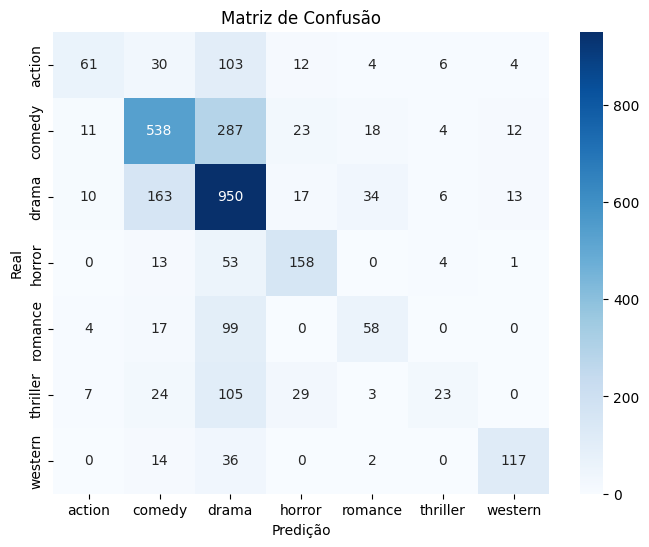

In [ ]:
gerar_matriz_confusao(X_test_bow, y_test_bow, modelo3_bow, label_encoder)

In [ ]:
# Marcar o fim
end_time = time.time()

# Calcular e imprimir o tempo de execução
execution_time_bow = end_time - start_time
print(f"Tempo de execução: {execution_time_bow:.6f} segundos")

Tempo de execução: 54.510746 segundos


# Doc2Vec

In [ ]:
start_time = time.time()

In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# 2. Preparar os dados para o Doc2Vec
documents = [TaggedDocument(words=plot.split(), tags=[str(i)]) for i, plot in enumerate(df_filtered['Processed_Plot'])]

# Definir o modelo Doc2Vec
doc2vec_model = Doc2Vec(vector_size=300, window=6, min_count=2, workers=4, epochs=40)
doc2vec_model.build_vocab(documents)
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# 3. Obter as representações vetoriais para cada plot
X_doc2vec = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])


In [ ]:

# Dividir os dados em conjunto de treinamento e teste
X_train_doc2vec, X_test_doc2vec, y_train_doc2vec, y_test_doc2vec = train_test_split(X_doc2vec, y, test_size=0.2, random_state=42)

# Verificar as dimensões dos dados
print(f"Tamanho do treinamento: {X_train_doc2vec.shape}")
print(f"Tamanho do teste: {X_test_doc2vec.shape}")



# Dividir o conjunto de treinamento em treino e validação
X_train_doc2vec, X_val, y_train_doc2vec, y_val = train_test_split(
    X_train_doc2vec, y_train_doc2vec, test_size=0.3, random_state=42
)

Tamanho do treinamento: (12289, 300)
Tamanho do teste: (3073, 300)


##  Rede Neural - MLP

In [ ]:

def doc2_vec():
    # 4. Definir o modelo
    model = Sequential()

    model.add(Dropout(0.4))
    # Camada densa para previsão do gênero, já que estamos lidando com vetores fixos
    model.add(Dense(128, activation='relu', input_dim=X_train_doc2vec.shape[1]))  # Usando input_dim ao invés de LSTM

    # Camada densa para previsão do gênero
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(selected_genres), activation='softmax'))

    # Compilar o modelo
    model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',  
                metrics=['accuracy'])
    return model

modelo4_doc2vec = doc2_vec()


# Definir o callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Treinamento do modelo com Early Stopping e validação apropriada
history = modelo4_doc2vec.fit(
    X_train_doc2vec, y_train_doc2vec, 
    validation_data=(X_val, y_val),  # Usar o conjunto de validação
    epochs=50, batch_size=32, 
    callbacks=[early_stopping]
)

Epoch 1/50


/home/digolira/Documents/ML/Anderson/PLN/Projetin/archive (2)/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4261 - loss: 1.5886 - val_accuracy: 0.5967 - val_loss: 1.0772
Epoch 2/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5772 - loss: 1.1169 - val_accuracy: 0.6230 - val_loss: 1.0317
Epoch 3/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5991 - loss: 1.0518 - val_accuracy: 0.6214 - val_loss: 1.0180
Epoch 4/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6087 - loss: 1.0143 - val_accuracy: 0.6306 - val_loss: 0.9961
Epoch 5/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6243 - loss: 0.9998 - val_accuracy: 0.6211 - val_loss: 0.9853
Epoch 6/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6262 - loss: 0.9754 - val_accuracy: 0.6287 - val_loss: 0.9900
Epoch 7/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6429 - loss: 0.9449 - val_accuracy: 0.6317 - val_loss: 0.9869
Epoch 8/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6344 - loss: 0.9379 - val_accuracy: 0.6360 - val_

In [ ]:

# Avaliar o modelo
loss, accuracy = modelo4_doc2vec.evaluate(X_test_doc2vec, y_test_doc2vec)
print(f'Accuracy on test data: {accuracy*100:.2f}%')



97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.6177 - loss: 1.0325
Accuracy on test data: 63.78%


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step

Métricas por classe:
     Classe    Recall  Precisão
0    action  0.477273  0.652174
1    comedy  0.592385  0.700662
2     drama  0.791282  0.603581
3    horror  0.781659  0.648551
4   romance  0.224719  0.555556
5  thriller  0.151832  0.432836
6   western  0.792899  0.752809

Acurácia Geral: 63.78%


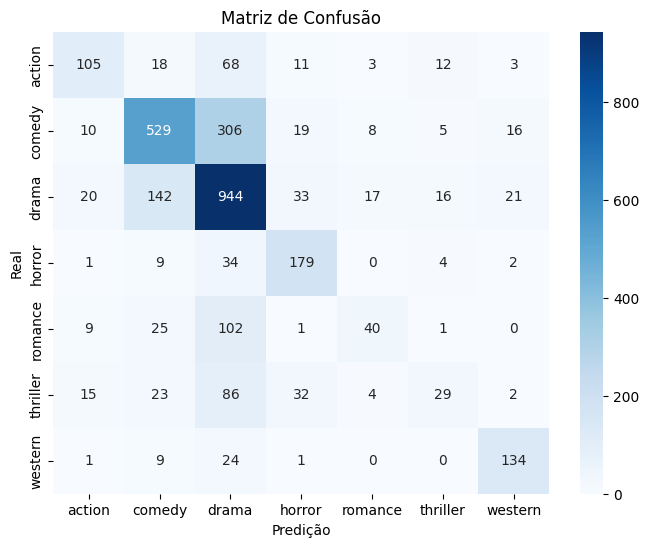

In [ ]:
gerar_matriz_confusao(X_test_doc2vec, y_test_doc2vec, modelo4_doc2vec, label_encoder)

In [ ]:
# Marcar o fim
end_time = time.time()

# Calcular e imprimir o tempo de execução
execution_time_doc2vec = end_time - start_time
print(f"Tempo de execução: {execution_time_doc2vec:.6f} segundos")

Tempo de execução: 161.482360 segundos


# TF-IDF

In [13]:
start_time = time.time()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Criar o vetor TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=7000)  # Limite de 7000 características para manter a dimensão razoável
X_tfidf = tfidf_vectorizer.fit_transform(df_filtered['Processed_Plot']).toarray()

# Atualizar os conjuntos de treinamento e teste com o TF-IDF
X_train_tfidf, X_test_tfidf, y_train_cat, y_test_cat = train_test_split(
    X_tfidf, 
    to_categorical(y, num_classes=len(selected_genres)), 
    test_size=0.2, 
    random_state=42
)

# Dividir o conjunto de treinamento em treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_train_tfidf, y_train_cat, test_size=0.2, random_state=42
)


# Obter o número de classes e de features
num_classes = len(selected_genres)
num_features = X_train_tfidf.shape[1]


modelo5_tfidf = Sequential([
    Input(shape=(num_features,)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_genres), activation='softmax')
])


# Compilar o modelo
modelo5_tfidf.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Adicionar callback para early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)



# Treinar o modelo com o conjunto de validação apropriado
history = modelo5_tfidf.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Usar o conjunto de validação
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)



W0000 00:00:1732207507.165383  222255 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3849 - loss: 1.6675 - val_accuracy: 0.5740 - val_loss: 1.1865
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6515 - loss: 0.9899 - val_accuracy: 0.6509 - val_loss: 0.9433
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7934 - loss: 0.6030 - val_accuracy: 0.6477 - val_loss: 0.9781
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8749 - loss: 0.3923 - val_accuracy: 0.6338 - val_loss: 1.0913
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9213 - loss: 0.2567 - val_accuracy: 0.6204 - val_loss: 1.2758
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9581 - loss: 0.1601 - val_accuracy: 0.6159 - val_loss: 1.4273


In [15]:

# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = modelo5_tfidf.evaluate(X_test_tfidf, y_test_cat, verbose=1)
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6419 - loss: 0.9738
Acurácia no conjunto de teste: 0.6521


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Métricas por classe:
     Classe    Recall  Precisão
0    action  0.490909  0.586957
1    comedy  0.624860  0.713555
2     drama  0.812238  0.616020
3    horror  0.820961  0.676259
4   romance  0.247191  0.536585
5  thriller  0.026178  0.277778
6   western  0.781065  0.846154

Acurácia Geral: 65.21%


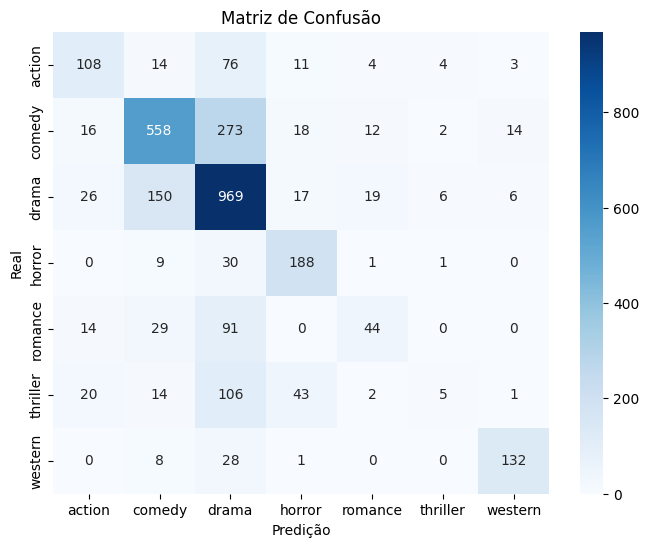

In [16]:

# Converter y_test_cat para rótulos de classe inteiros
y_test_labels = np.argmax(y_test_cat, axis=1)

# Chamar a função com os rótulos ajustados
gerar_matriz_confusao( X_test_tfidf, y_test_labels, modelo5_tfidf, label_encoder)

In [17]:
# Marcar o fim
end_time = time.time()

# Calcular e imprimir o tempo de execução
execution_time_tfidf = end_time - start_time
print(f"Tempo de execução: {execution_time_tfidf:.6f} segundos")

Tempo de execução: 20.112378 segundos
